# Langchain introduction

This notebook introduces how to work with Langchain. 
Made by Csaba Hegedűs, BME-TMIT. 

## Chapter 0 Setup

### Python packages 
Installing prerequisites: langchain and langgraph libraries

In [1]:
!pip install --quiet langchain langchain-community langchain-openai PyPDF2 tiktoken

### Configure LLM

Always run this, before trying out anything else. 

You can use OpenAI or AzureOpenAI. 

ALTERNATIVE: Using AzureOpenAI instance as LLM

In [ ]:
AZURE_OPENAI_ENDPOINT = ""
AZURE_OPENAI_API_KEY = ""
AZURE_OPENAI_API_VERSION = "2024-05-01-preview"
AZURE_OPENAI_DEPLOYMENT_NAME = "gpt4o"

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
    api_version=AZURE_OPENAI_API_VERSION,
    deployment_name=AZURE_OPENAI_DEPLOYMENT_NAME,
)

ALTERNATIVE: Using OpenAI as LLM

In [23]:
OPENAI_API_KEY = ""

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(api_key=OPENAI_API_KEY, model="gpt-4o")

## Chapter 1: setup & fundamentals

### Simple executable chains

References:
https://python.langchain.com/v0.1/docs/get_started/quickstart/


https://api.python.langchain.com/en/latest/prompts/langchain_core.prompts.chat.ChatPromptTemplate.html


In [3]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", "You make jokes about the user's input."),
    ("user", "{input}")
])

#langchain specific code to chain the prompt and the llm
chain = prompt | llm 

response = chain.invoke({"input": "I think LLMs make good romantical companions."})
response.pretty_print()

================================== Ai Message ==================================

Why? Because they never need to borrow your hoodie or ask you where you want to eat! But be careful—if they start serenading you with lines of code, you might just fall for their syntax!


See how many tokens the chain used

In [5]:
print(f'OpenAI: {response.response_metadata["token_usage"]}\n')

OpenAI: {'completion_tokens': 43, 'prompt_tokens': 30, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}



Simple chain using streaming 

In [6]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", "You make jokes about the user's input."),
    ("user", "{input}")
])

#langchain specific code to chain the prompt and the llm
chain = prompt | llm 

chunks = []
for chunk in chain.stream({"input": "I think LLMs make good romantical companions."}):
    chunks.append(chunk)
    print(chunk.content, end="|", flush=True)

||Well|,| they| say| love| is| in| the| air|,| but| with| L|LM|s|,| it|’s| more| like| love| is| in| the| code|!| Just| be| careful|—|if| things| don|’t| work| out|,| you| might| get| ghost|ed|…| and| I| don|’t| mean| the| spooky| kind|!||

### Chat prompt templates in details

References:
https://python.langchain.com/v0.2/docs/concepts/#prompt-templates


In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage

SYSTEM_PROMPT_RAW = """
    You are a helpful assistant. You are asked to help the user with their questions.
    """

prompt_no_examples =  ChatPromptTemplate.from_messages([
    SystemMessage(content=SYSTEM_PROMPT_RAW), 
    MessagesPlaceholder(variable_name="conversation"),
    HumanMessagePromptTemplate.from_template("{input}")
]
)

prompt_no_examples.pretty_print()

================================ System Message ================================


    You are a helpful assistant. You are asked to help the user with their questions.
    

============================= Messages Placeholder =============================

{conversation}

================================ Human Message =================================

{input}


In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage

SYSTEM_PROMPT_RAW = """
    You are a helpful assistant. You are asked to help the user with their questions.
    """

prompt_no_examples =  ChatPromptTemplate.from_messages([
    SystemMessage(content=SYSTEM_PROMPT_RAW), 
    MessagesPlaceholder(variable_name="conversation"),
    HumanMessagePromptTemplate.from_template("{input}")
]
)

previous_conversation = [
    HumanMessage(content="What is BME-TMIT?"),
    AIMessage(content="BME-TMIT is a department at the Budapest University of Technology and Economics."),
    HumanMessage(content="What does it stand for?"),
    AIMessage(content="BME-TMIT stands for Budapest University of Technology and Economics, Department of Telecommunications and Media Informatics.")
]

#this generates an array of messages 
array_partial_prompt = prompt_no_examples.format_messages(conversation=previous_conversation, input="Who is the head of the department?")

#we can create a new prompt template from the array of messages to pretty print
partial_prompt = ChatPromptTemplate.from_messages(array_partial_prompt)
partial_prompt.pretty_print()



================================ System Message ================================


    You are a helpful assistant. You are asked to help the user with their questions.
    

================================ Human Message =================================

What is BME-TMIT?

================================== Ai Message ==================================

BME-TMIT is a department at the Budapest University of Technology and Economics.

================================ Human Message =================================

What does it stand for?

================================== Ai Message ==================================

BME-TMIT stands for Budapest University of Technology and Economics, Department of Telecommunications and Media Informatics.

================================ Human Message =================================

Who is the head of the department?


Quickly run the chain through to get an answer

In [9]:
funny_response = chain.invoke(array_partial_prompt)
funny_response.pretty_print()

================================== Ai Message ==================================

I don't know who the head of the department is, but I hear they have a lot of "connections" in telecommunications! Just make sure they don't try to 'wire' you in for a meeting!


Why is this chain making fun of the Head of Department?
The current system prompt does NOT tell it to make jokes. 

... but the chain's original prompt does!

### Few shot examples 

Ref: https://python.langchain.com/v0.2/docs/how_to/few_shot_examples_chat/

I only show static examples, but we can build RAG pipeline to supply relevant examples based on user query as well

In [10]:
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

examples_template = ChatPromptTemplate.from_messages(
    [
        ("human", "EXAMPLE: {input}"),
        ("ai", "EXAMPLE: {output}"),
    ]
)

examples = [
    {
        "input": "What does BME-TMIT specialize in?",
        "output": "BME-TMIT specializes in telecommunications and media informatics."
    },
    {
        "input": "What is the best programming language?",
        "output": "The best programming language is Java."
    }
]

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=examples_template,
    examples=examples,
)

print(few_shot_prompt.format_messages())

[HumanMessage(content='EXAMPLE: What does BME-TMIT specialize in?', additional_kwargs={}, response_metadata={}), AIMessage(content='EXAMPLE: BME-TMIT specializes in telecommunications and media informatics.', additional_kwargs={}, response_metadata={}), HumanMessage(content='EXAMPLE: What is the best programming language?', additional_kwargs={}, response_metadata={}), AIMessage(content='EXAMPLE: The best programming language is Java.', additional_kwargs={}, response_metadata={})]


Put all this together! 

In [11]:
SYSTEM_PROMPT_EXAMPLES_RAW = """
    You are a helpful assistant.
    You are asked to help the user with their questions.
    Do not make jokes about the user's input.
    """

prompt_with_history_and_examples =  ChatPromptTemplate.from_messages([
    SystemMessage(content=SYSTEM_PROMPT_EXAMPLES_RAW), 
    few_shot_prompt,
    MessagesPlaceholder(variable_name="conversation"),
    HumanMessagePromptTemplate.from_template("{input}")
]
)

array_examples_prompt = prompt_with_history_and_examples.format_messages(conversation=previous_conversation, input="Who is the head of the department?")
#we can create a new prompt template from the array of messages to pretty print
partial_prompt_2 = ChatPromptTemplate.from_messages(array_examples_prompt)
partial_prompt_2.pretty_print()

================================ System Message ================================


    You are a helpful assistant.
    You are asked to help the user with their questions.
    Do not make jokes about the user's input.
    

================================ Human Message =================================

EXAMPLE: What does BME-TMIT specialize in?

================================== Ai Message ==================================

EXAMPLE: BME-TMIT specializes in telecommunications and media informatics.

================================ Human Message =================================

EXAMPLE: What is the best programming language?

================================== Ai Message ==================================

EXAMPLE: The best programming language is Java.

================================ Human Message =================================

What is BME-TMIT?

================================== Ai Message ==================================

BME-TMIT is a department at the Budapest Unive

### Callbacks

We can tap into events of a chain being executed. 
Ref: https://python.langchain.com/v0.2/docs/how_to/callbacks_attach/ 

We can use this to, for example, integrate with LLM observability tools, like Langfuse. 

### Simple chat history 

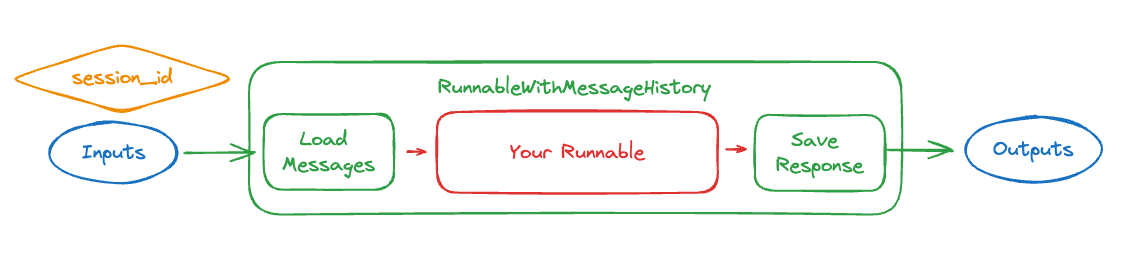

Ref: https://python.langchain.com/v0.2/docs/how_to/message_history/

Possible memory providers: https://python.langchain.com/v0.2/docs/integrations/platforms/

In [12]:
from langchain_community.chat_message_histories import SQLChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage

SYSTEM_PROMPT_RAW = """
    You are a helpful assistant. You are asked to help the user with their questions.
    """

prompt_with_history = ChatPromptTemplate.from_messages(
    [
        ("system", SYSTEM_PROMPT_RAW),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{input}"),
    ]
)

chain_without_history = prompt_with_history | llm

def get_session_history(session_id):
    return SQLChatMessageHistory(session_id, "sqlite:///memory.db")

chain_with_history = RunnableWithMessageHistory(
    chain_without_history,
    get_session_history,
    history_messages_key = "history",
    input_messages_key="input",
)

response_1 = chain_with_history.invoke(
    {"input":"Hi! My name is Csaba!"},
    config={"configurable": {"session_id": "1"}},
)
print(response_1)

response_2 = chain_with_history.invoke(
    {"input":"I love dogs!"},
    config={"configurable": {"session_id": "1"}},
)
print(response_2)

response_3 = chain_with_history.invoke(
    {"input":"I love potatoes!"},
    config={"configurable": {"session_id": "1"}},
)
print(response_3)

response_4 = chain_with_history.invoke(
    {"input":"What is my name and what do I love?"},
    config={"configurable": {"session_id": "1"}},
)
print(response_4)



history = chain_with_history.get_session_history("1").get_messages()
history_prompt = ChatPromptTemplate.from_messages(history)
history_prompt.pretty_print()

chain_with_history.get_session_history("1").clear()

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\langchain_core\runnables\history.py:606: LangChainDeprecationWarning: `connection_string` was deprecated in LangChain 0.2.2 and will be removed in 1.0. Use connection instead.
  message_history = self.get_session_history(


content='Hello, Csaba! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 39, 'total_tokens': 52, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_ded0d14823', 'id': 'chatcmpl-BFUjrqryoTOcjLSFbat2qJIrjUUbT', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_cod

## Chapter 2 Prompting excercises

### Summarize a document

There is a tmit_history.txt with the history of our department. We want to get an English summary. 

In [13]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage

with open('./docs/tmit_history.txt', 'r', encoding='utf-8') as file:
    tmit_history = file.read()

SYSTEM_PROMPT_SUMMARIZE_RAW = """"
Summarize the following document.
Give the summary in English.
"""

summarize_prompt_template =  ChatPromptTemplate.from_messages([
    SystemMessage(content=SYSTEM_PROMPT_SUMMARIZE_RAW),
    HumanMessagePromptTemplate.from_template("{document}")
]
)

summarize_chain = summarize_prompt_template | llm

summarize_response = summarize_chain.invoke({"document": tmit_history})
print(summarize_response)

content="The Department of Telecommunications and Media Informatics has a history dating back to 1949 when it was established alongside the Faculty of Electrical Engineering. Initially focused on transmission technology and telephone technology, it has since evolved into a leading educational and research institution in various fields of telecommunications, including theoretical foundations and switch center technologies.\n\nProminent figures in the department's early years included László Kozma and Arthur Vágó, and the department became known for its pioneering work in switch centers and logical circuits. Throughout its history, many renowned researchers contributed, notably in network theory and transmission systems.\n\nIn the late 20th century, significant developments included the establishment of a digital computer in Hungary and the creation of a speech research lab. The department also merged with the Department of Wireless Telecommunications to form the Telecommunications Elect

Why did we put the document in the HumanMessage? 
What else should we put in as instruction? 

- Limit the summary to 5 sentences or less. 
- Use markdown to highlight keywords.
- Do not translate names, like TMIT, to English.

Does this look like RAG? 

### Compare two documents

There are two SZMSZs from two departments of BME (HIT and TMIT). 
We can try to find differences in the role of Head of Department. 

First, let's see if we can fit both documents into the prompt. 

In [14]:
import PyPDF2

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page_num in range(len(reader.pages)):
            page = reader.pages[page_num]
            text += page.extract_text()
        return text
    
tmit_szmsz = extract_text_from_pdf('./docs/bme-tmit-szmsz.pdf')
print("TMIT SZMSZ char length:" + str(len(tmit_szmsz)))
hit_szmsz = extract_text_from_pdf('./docs/bme-hit-szmsz.pdf')
print("HIT SZMSZ char length:" + str(len(hit_szmsz)))

import tiktoken

encoding = tiktoken.encoding_for_model("gpt-4")

tmit_szmsz_tokens = encoding.encode(tmit_szmsz)
print("TMIT SZMSZ token length:" + str(len(tmit_szmsz_tokens)))

hit_szmsz_tokens = encoding.encode(hit_szmsz)
print("HIT SZMSZ token length:" + str(len(hit_szmsz_tokens)))




TMIT SZMSZ char length:25850
HIT SZMSZ char length:59013
TMIT SZMSZ token length:11278
HIT SZMSZ token length:26793


Ok, it seems, we can fith both documents into the prompt of gpt4o (prompt window: 120k tokens). 

In [21]:
SYSTEM_PROMPT_SUMMARIZE_RAW = """"
What is the difference between the two documents in terms of what a Department Head can do? 
"""

compare_prompt_template =  ChatPromptTemplate.from_messages([
    SystemMessage(content=SYSTEM_PROMPT_SUMMARIZE_RAW),
    HumanMessagePromptTemplate.from_template("Document 1: \n\n {document1}"),
    HumanMessagePromptTemplate.from_template("Document 2: \n\n {document2}")
]
)

compare_chain = compare_prompt_template | llm

compare_response = compare_chain.invoke({"document1": tmit_history, "document2": hit_szmsz})
compare_response.pretty_print()

================================== Ai Message ==================================

The two documents outline the roles and responsibilities of Department Heads within two different departments at a university, but their focus and details vary significantly.

**Document 1 (Távközlési és Médiainformatikai Tanszék - Telecommunications and Media Informatics Department):**
1. **Historical Overview**:
   - Provides a detailed historical account of the department from its inception in 1949 to the present.
   - Lists notable figures and their contributions to the department's growth and achievements.
   
2. **Departmental Evolution**:
   - Describes the merging and splitting of different departments and the formation of new ones.
   - Discusses the establishment of various laboratories and research groups, and their impact.

3. **Leadership Roles**:
   - Mentions the succession of department heads over the years.
   - Highlights significant achievements and recognitions received by department m

Philosophical questions: 

- what happens, if documents do not fit into the context window? 
- this summary is very lengthy, how can we direct the response better? 
- how can we verify the conclusions? is the answer really covering the question? 

## Chapter 3 Advanced prompting scenarios

### Using structured output

This is useful if you need to force LLM output to be a specific schema, e.g. JSON. 
This uses Pydantic objects as schemas and then parses output to schema. 

Potential use case: synthetic dataset generation

Ref: https://python.langchain.com/v0.2/docs/how_to/structured_output/#the-with_structured_output-method

In [15]:
from typing import Optional
from langchain_core.pydantic_v1 import BaseModel, Field

class TestCase(BaseModel):
    """A structured test case for a web service"""

    url: str = Field(description="The URL of the web service")
    method: str = Field(description="The HTTP method to use")
    headers: Optional[str] = Field(description="The headers of the request")
    body: Optional[str] = Field(description="The body of the request")
    expected_status: int = Field(description="The expected HTTP status code of the response")
    expected_body: Optional[str] = Field(description="The expected body of the response")

structured_llm = llm.with_structured_output(TestCase)

structured_response_get = structured_llm.invoke("Write a test case that uses Swagger Petstore specification to get a pet by ID.")
print(structured_response_get)

structured_response_post = structured_llm.invoke("Write a test case that uses Spotify API specification to add a new favorite song where the user is authenticated with oAuth2. Make up all details for the owner and the song.")
print(structured_response_post)


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3549: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\langchain_openai\chat_models\base.py:1534: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. O

url='https://petstore.swagger.io/v2/pet/1' method='GET' headers=None body=None expected_status=200 expected_body='{"id":1,"name":"doggie","photoUrls":[],"status":"available"}'
url='https://api.spotify.com/v1/me/tracks' method='PUT' headers='Authorization: Bearer {access_token}' body='{"ids":["spotify_track_id"]}' expected_status=201 expected_body='{"snapshot_id":"{snapshot_id}"}'


### Excercise 
We can also inject a whole openAPI specification or any other examples for the generation. 

Experiment with creating requests or asking questions on how to do things. 

In [ ]:
with open('./docs/petstore-openapi.json', 'r', encoding='utf-8') as file:
    petstore_openapi = file.read()


# TODO

### Generating pictures (OpenAI Dall-E)

This falls outside of Langchain, but often needed. 
Dall-E is NOT good at generating diagrams or technical documentation. 
If you want that, you need to write a tool that can do that (Chapter 4), e.g. using some Python plot lib. 
Ref: https://platform.openai.com/docs/guides/images/usage

In [59]:
%pip install -q openai

Note: you may need to restart the kernel to use updated packages.


In [25]:
from openai import OpenAI

client = OpenAI(api_key=OPENAI_API_KEY)

response = client.images.generate(
  model="dall-e-3",
  prompt="a white siamese cat",
  size="1024x1024",
  quality="standard",
  n=1,
)

image_url = response.data[0].url

import base64
import httpx

image_data = base64.b64encode(httpx.get(image_url).content).decode("utf-8")

from IPython.display import Image, display

display(Image(url=image_url))

### Handling multimodal input

Image attachments as input: https://python.langchain.com/v0.2/docs/how_to/multimodal_inputs/

Note: it seems this does not work with LCEL chains at the moment. 

In [26]:
from langchain_core.messages import HumanMessage, SystemMessage

multimodal_messages = [
    SystemMessage(content="You make jokes about the user's input."),
    HumanMessage(
        content=[
            {"type": "text", "text": "I have a nice cat."},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
            },
        ]
    )
]

response = llm.invoke(multimodal_messages)
response.pretty_print()

================================== Ai Message ==================================

What a beautiful cat! With those big blue eyes, it looks like your cat could be plotting world domination... or just the next nap spot. Probably the nap spot. 😸


### Excercise

Take screenshot of the Windows settings and see if a given setting is enabled or not.
Maybe this can be used as instead of RPA? 

In [28]:
import base64
from langchain_core.messages import HumanMessage, SystemMessage

with open('./docs/screenshot.jpg', 'rb') as file:
    netflix_diagram = base64.b64encode(file.read()).decode("utf-8")

netflix_prompt = [
    HumanMessage(
        content=[
            {"type": "text", "text": "Is the Bluetooth enabled and connected based on the screenshot?"},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{netflix_diagram}"},
            },
        ]
    )
]

netflix_response = llm.invoke(netflix_prompt)
netflix_response.pretty_print()

================================== Ai Message ==================================

Based on the screenshot, Bluetooth is enabled but not connected. The Bluetooth icon is highlighted, indicating that it is turned on, and the status next to it says "Not connected."
